In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

In [ ]:

max_words = 10000
max_len = 200
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)


In [ ]:
N_train = 5000
N_test = 1000
X_train = X_train[:N_train]
y_train = y_train[:N_train]
X_test = X_test[:N_test]
y_test = y_test[:N_test]

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)

        last_hidden = hidden.squeeze(0)
        out = self.fc1(last_hidden)
        out = self.fc2(out)
        return out

In [ ]:
vocab_size = max_words
embedding_dim = 2
hidden_dim = 32
output_dim = 1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)

In [ ]:

num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        probs = torch.sigmoid(outputs)
        loss = criterion(probs, y_batch.float())
        loss.backward()
        optimizer.step()

        preds = (probs > 0.5).long()
        correct_train += (preds == y_batch).sum().item()
        running_loss += loss.item() * X_batch.size(0)


    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = correct_train   / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)


    model.eval()
    running_val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze(1)
            probs = torch.sigmoid(outputs)
            loss = criterion(probs, y_batch.float())

            running_val_loss += loss.item() * X_batch.size(0)
            preds = (probs > 0.5).long()
            correct_val += (preds == y_batch).sum().item()

    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    epoch_val_acc  = correct_val       / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}  "
          f"Train Loss: {epoch_train_loss:.4f}  "
          f"Train Acc: {epoch_train_acc:.4f}  "
          f"Val Loss: {epoch_val_loss:.4f}  "
          f"Val Acc: {epoch_val_acc:.4f}")


Epoch 1/100  Train Loss: 0.6944  Train Acc: 0.5036  Val Loss: 0.6958  Val Acc: 0.4690
Epoch 2/100  Train Loss: 0.6925  Train Acc: 0.5098  Val Loss: 0.6998  Val Acc: 0.4750
Epoch 3/100  Train Loss: 0.6922  Train Acc: 0.5116  Val Loss: 0.6960  Val Acc: 0.4750
Epoch 4/100  Train Loss: 0.6910  Train Acc: 0.5102  Val Loss: 0.6970  Val Acc: 0.4760
Epoch 5/100  Train Loss: 0.6898  Train Acc: 0.5236  Val Loss: 0.7018  Val Acc: 0.4820
Epoch 6/100  Train Loss: 0.6876  Train Acc: 0.5206  Val Loss: 0.6962  Val Acc: 0.5120
Epoch 7/100  Train Loss: 0.6837  Train Acc: 0.5372  Val Loss: 0.7008  Val Acc: 0.5240
Epoch 8/100  Train Loss: 0.6868  Train Acc: 0.5296  Val Loss: 0.7065  Val Acc: 0.5000
Epoch 9/100  Train Loss: 0.6922  Train Acc: 0.5216  Val Loss: 0.7016  Val Acc: 0.4800
Epoch 10/100  Train Loss: 0.6874  Train Acc: 0.5380  Val Loss: 0.6961  Val Acc: 0.5120
Epoch 11/100  Train Loss: 0.6847  Train Acc: 0.5392  Val Loss: 0.7022  Val Acc: 0.4890
Epoch 12/100  Train Loss: 0.6792  Train Acc: 0.5540 

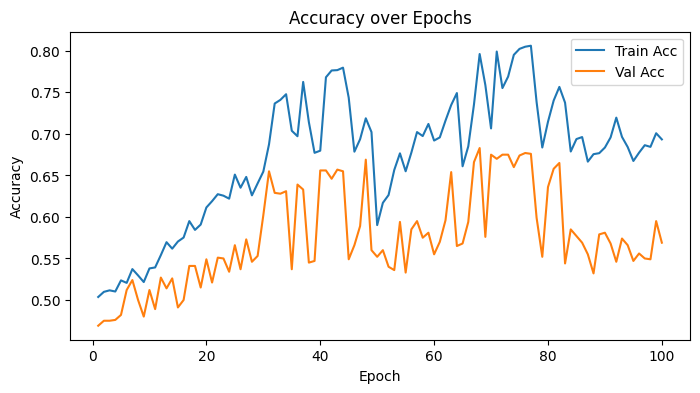

In [ ]:
epochs = range(1, num_epochs+1)

# --- Accuracy plot ---
plt.figure(figsize=(8,4))
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies,   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

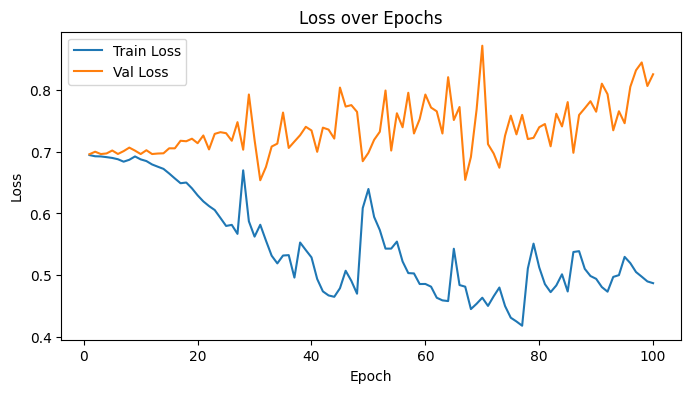

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

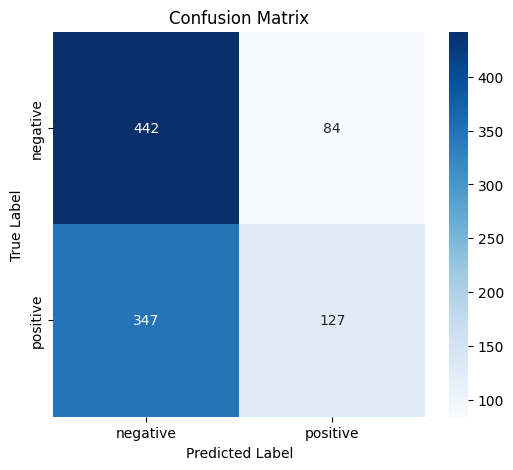

In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze(1)
        probabilities = torch.sigmoid(outputs)
        preds = probabilities > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())


cm = confusion_matrix(all_labels, all_preds)
classes = ['negative', 'positive']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()